# **The basics**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kenoz/SITS_utils/blob/main/docs/source/tutorials/colab_sits_ex01.ipynb)

---

We aim to follow the **geomorphological evolution** of the **Banc d'Arguin**.

> _"The Banc d'Arguin is a sandbank about 4 km long and 2 km wide at low tide. The bank is more or less visible depending on the state of the tide. In addition, under the action of sea currents, tides and wind, it continually changes shape and location. It is located opposite the entrance to the Arcachon basin, between the Dune du Pilat and the tip of Cap Ferret"_ (source: [wikipedia](https://fr.wikipedia.org/wiki/R%C3%A9serve_naturelle_nationale_du_Banc-d%27Arguin)).

<p align="center"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Parc_naturel_marin_du_bassin_d%27Arcachon_vu_du_ciel_-_Banc_d%27Arguin_%281%29.JPG/1280px-Parc_naturel_marin_du_bassin_d%27Arcachon_vu_du_ciel_-_Banc_d%27Arguin_%281%29.JPG" alt="Banc d'Arguin" width="600"></p>
<p align="center"><sup>Arcachon Basin Marine Natural Park seen from the sky, from a light aircraft Tecnam P2002 (&copy; Dorian Bentejac)</sup></p>

We begin with a vector file that defines the spatial extent of the sandbank. Using this geometry, we’ll extract a time series of Sentinel-2 imagery from a STAC-compliant catalog—specifically, the Microsoft Planetary Computer.

Starting with **processing baseline 04.00** (January 2022), Sentinel-2 Level-1C products include a **radiometric offset** that shifts reflectance values by a band-specific constant. This adjustment alters the dynamic range and introduces a temporal discontinuity. We’ll demonstrate how to correct this bias to ensure consistency across the time series.

Next, each image will be processed with a **cloud mask** to exclude cloud-contaminated pixels. Remaining gaps and nodata values will be filled using **temporal interpolation**, producing a continuous and coherent signal over time.

Finally, the cleaned and gap-filled time series will be exported as a **netCDF file** for further analysis or visualization.

---

## 1. Installation of `sits` package and its depedencies

First, install `sits` package with [pip](https://pypi.org/project/SITS/). We also need some other packages for displaying data.

In [1]:
# SITS package
!pip install -q --upgrade sits

# other packages
!pip install -q mapclassify
#!pip install -q folium
#!pip install -q matplotlib

Now we can import `sits` and some other libraries.

In [ ]:
import os
import matplotlib.pyplot as plt
# sits lib
from sits import sits, export
# geospatial libs
import xarray as xr
import geopandas as gpd
import pandas as pd
# date format
from datetime import datetime
# ignore warnings messages
import warnings
warnings.filterwarnings('ignore')

## 2. Handling the input vector file

### 2.1. Data loading

The geojson vector file describing the position of the sandbank is stored in the [Github repository](https://github.com/kenoz/SITS_utils). We download it into our current workspace.  

In [3]:
!mkdir -p test_data
![ ! -f test_data/banc_arguin.geojson ] && wget https://raw.githubusercontent.com/kenoz/SITS_utils/refs/heads/main/sits/data/banc_arguin.geojson -P test_data

We load the vector file, named `banc_arguin.geojson`, as a geoDataFrame object with the `sits` method: `sits.Vec2gdf()`.

In [4]:
data_dir = 'test_data'
v_arguin = sits.Vec2gdf(os.path.join(data_dir, 'banc_arguin.geojson'))
v_arguin.gdf

,id,id_poly,geometry
0,1,1,"MULTIPOLYGON (((-1.27422 44.63147, -1.19528 44..."


### 2.2. Bounding box calculation

We check the coordinate reference system (CRS) and calculate the bounding box with the method `set_bbox()` of class `sits.Vec2gdf`.

In [5]:
# check epsg
print(f"epsg code for 'v_arguin.gdf':  {v_arguin.gdf.crs.to_epsg()}")

# calculates the bounding box for each feature.
v_arguin.set_bbox('gdf')
print(f"epsg code for 'v_arguin.bbox': {v_arguin.bbox.crs.to_epsg()}")

epsg code for 'v_arguin.gdf':  4326
epsg code for 'v_arguin.bbox': 4326


We display the `sits.Vec2gdf` objects (`.gdf` _in green_ and `.bbox` _in blue_) on an interactive map.

In [6]:
import folium

f = folium.Figure(height=300)
m = folium.Map(location=[44.6, -1.2], zoom_start=11).add_to(f)
v_arguin.gdf.explore(m=m, height=400, color='green')
v_arguin.bbox.explore(m=m, height=400)

### 2.3. CRS management

To query data from a STAC catalog, we first need to define the area of interest using bounding box coordinates in geographic latitude/longitude, i.e. in the EPSG:4326 reference system. We must also specify the target coordinate reference system (CRS) for retrieving the satellite time series. Since our study area is in France, suitable choices include EPSG:2154 (RGF93 / Lambert-93) for national-scale applications, or EPSG:3035 (ETRS89 / LAEA Europe) for analyses at the continental level.

In this example, we compute the bounding box coordinates in both EPSG:4326 and EPSG:3035. As the geometry consists of a single polygon, we store the transformed coordinates in two separate lists for further use.

In [7]:
bbox_4326 = list(v_arguin.bbox.iloc[0]['geometry'].bounds)
bbox_3035 = list(v_arguin.bbox.to_crs(3035).iloc[0]['geometry'].bounds)

print(f'bbox in EPSG:4326: {bbox_4326}')
print(f'bbox in EPSG:3035: {bbox_3035}')

bbox in EPSG:4326: [-1.283356958716803, 44.54723753300113, -1.195282436226136, 44.63147049370678]
bbox in EPSG:3035: [3426472.0201418595, 2448438.7064564982, 3434719.22278734, 2458751.114093349]


## 3. Loading and preprocessing of a Satellite Image Time-Series (SITS)

In this example, we work with a single area of interest—represented by one polygon. We use the `sits.StacAttack` class to query and preprocess the corresponding satellite data. If you need to scale up to multiple geometries or larger regions, consider using the `sits.Multiproc()` approach, which leverages **Dask** for distributed processing and improved performance.

### 3.1. Creation of a Datacube from STAC catalog

The request consists in retrieving Sentinel-2 images (level 2A) acquired from January 1, 2016 to January 1, 2025 with cloud cover less than 20%. Then we build a 4 bands geo-datacube ('B03', 'B04', 'B08' and 'SCL') in EPSG:3035 with a 40m spatial resolution.

In [25]:
# instance of the class sits.StacAttack()
ts_S2 = sits.StacAttack(provider='mpc',
                        collection='sentinel-2-l2a',
                        bands=['B03', 'B04', 'B08', 'SCL'])

# search of items based on bbox coordinates and time interval criteria
ts_S2.searchItems(bbox_4326,
                  date_start=datetime(2016, 1, 1),
                  date_end=datetime(2025, 1, 1),
                  query={"eo:cloud_cover": {"lt": 20}}
                 )
# load of the time series in a lazy way
ts_S2.loadCube(bbox_3035, resolution=40, crs_out=3035)

The method `StacAttack.loadCube()` returns an object `StacAttack.cube` i.e. an `xarray.Dataset()`. If necessary, you can modify it using the methods of `xarray.Dataset()` (not really recommended).

In [26]:
type(ts_S2.cube)

xarray.core.dataset.Dataset

### 3.2. Plotting satellite time series

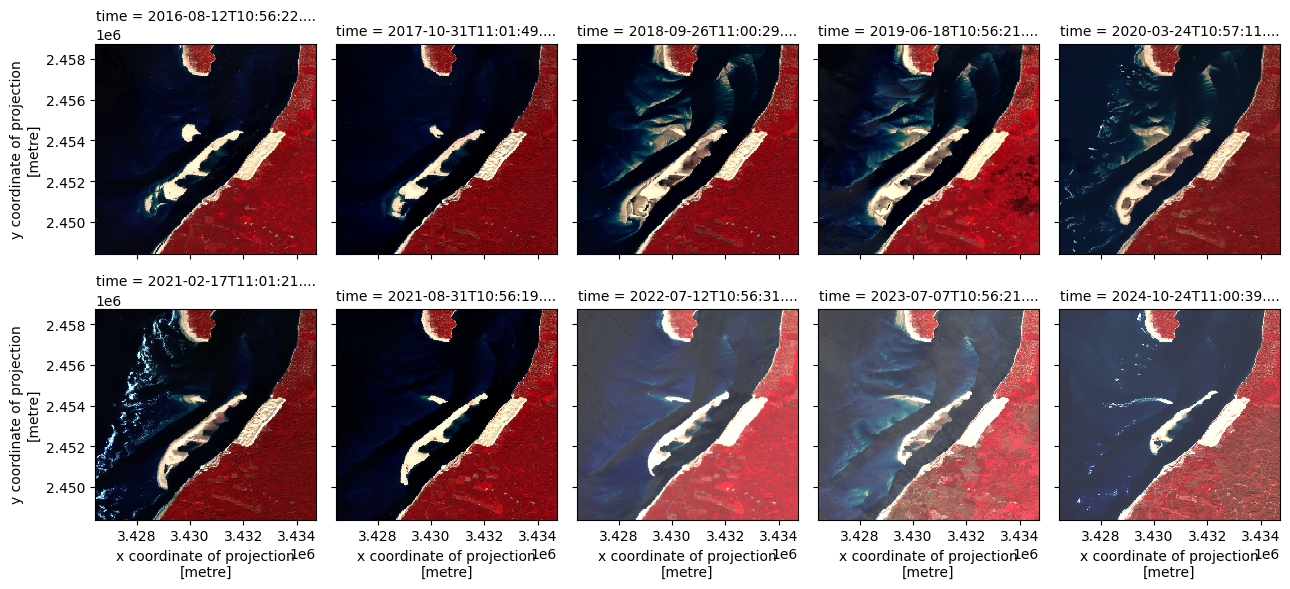

In [27]:
R = ts_S2.cube["B08"]
G = ts_S2.cube["B04"]
B = ts_S2.cube["B03"]

rgb = xr.concat([R, G, B], dim="band")
rgb = rgb.isel(time=slice(10, None, 15))
rgb.plot.imshow(col_wrap=5, col="time", robust=True, aspect=0.8, size=3)

## 4. Correcting radiometric offsets in Sentinel-2 imagery

Starting with processing baseline 04.00 (January 2022), Sentinel-2 Level-1C products include a band-specific radiometric offset that shifts reflectance values by a constant. This change affects the dynamic range and can introduce inconsistencies when analyzing time series data across multiple acquisition dates.

In this section, we’ll identify and correct these offsets to ensure radiometric continuity throughout the time series. This step is essential for reliable temporal analysis, especially when comparing surface reflectance values before and after the baseline update.

## 4.1. Plotting the uncorrected time series for a single pixel

In this step, we visualize the raw reflectance time series for the pixel located at coordinates _i_=200, _j_=90. The red dashed vertical line marks the introduction of Sentinel-2 processing baseline 04.00, which began on January 1, 2022. This baseline introduced a radiometric offset that affects the continuity of reflectance values across time.

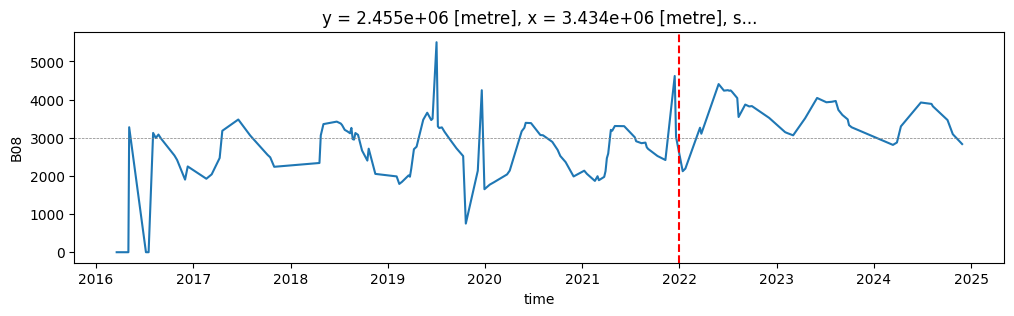

In [28]:
ts_S2.cube.B08.isel(x=200, y=90).plot(figsize=(12, 3))
plt.axhline(y=3000, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=datetime(2022, 1, 1), color='red', linestyle='--', linewidth=1.5)

### 4.2. Plotting the corrected time series for a single pixel

The `StacAttack` class includes an attribute (`data_corrected`) that indicates whether the time series has already been corrected for radiometric offsets. If not, we can invoke the `StacAttack.fix2shift()` method to harmonize reflectance values acquired from 2022 onward with those from earlier acquisitions. This correction ensures temporal consistency across the processing baseline transition.

In [29]:
print(f"Is the time series corrected? {ts_S2.data_corrected}")
ts_S2.fixS2shift()
print(f"Is the time series corrected? {ts_S2.data_corrected}")

Is the time series corrected? False
Is the time series corrected? True


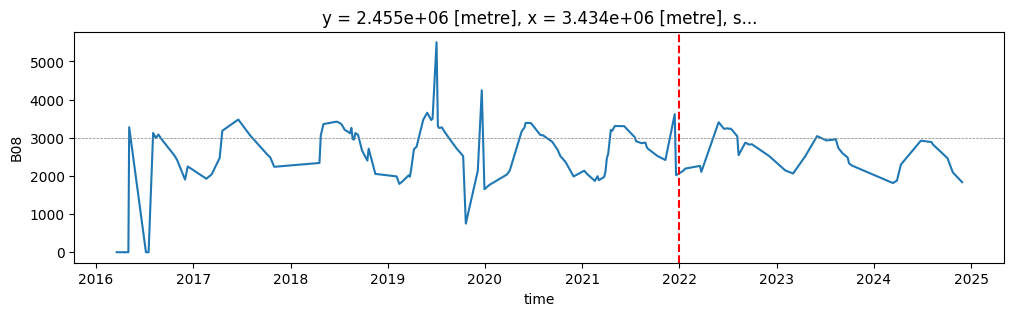

In [30]:
ts_S2.cube.B08.isel(x=200, y=90).plot(figsize=(12, 3))
plt.axhline(y=3000, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=datetime(2022, 1, 1), color='red', linestyle='--', linewidth=1.5)

## 5. Masking cloudy pixels and gap-filling

### 5.1. Create and apply a mask

We want to mask the defective and cloudy pixels in the Datacube (`StacAttack.cube`). To do this, we use the **SCL band** provided with the Sentinel-2 images. SCL refers to "Scene Classification Layer" and has been developed to developed to distinguish between cloudy pixels, clear pixels and water pixels. It consists of 12 classes.

In this example we create a mask based on the following classes:
- 0: No Data (Missing data)
- 1: Saturated or defective pixel
- 3: Cloud shadows
- 8: Cloud medium probability
- 9: Cloud high probability
- 10: Thin cirrus



In [31]:
# classes used to mask
SCL_mask = [0, 1, 3, 8, 9, 10]
# creation of the SCL mask
ts_S2.mask(mask_band='SCL', mask_values=[SCL_mask])

The method `StacAttack.mask()` returns an object `StacAttack.mask` i.e. an `xarray.Dataaarray()`.

In [32]:
ts_S2.mask

<xarray.DataArray 'SCL' (time: 147, y: 259, x: 207)> Size: 8MB
dask.array<any-aggregate, shape=(147, 259, 207), dtype=bool, chunksize=(1, 259, 207), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 2.459e+06 2.459e+06 ... 2.448e+06 2.448e+06
  * x            (x) float64 2kB 3.426e+06 3.426e+06 ... 3.435e+06 3.435e+06
  * time         (time) datetime64[ns] 1kB 2016-03-18T11:11:02.030000 ... 202...
    spatial_ref  int64 8B 0

We can apply the mask on the Satellite Image Time Series with the method `StacAttack.mask()`.

In [33]:
ts_S2.mask_apply()

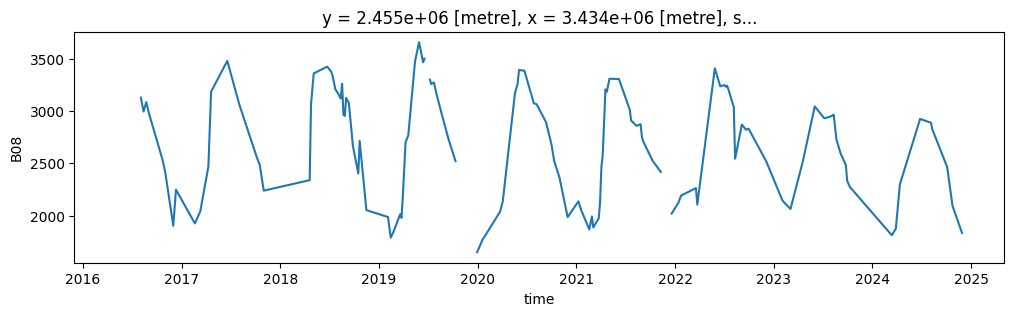

In [44]:
ts_S2.cube.B08.isel(x=200, y=90).plot(figsize=(12, 3))

### 5.2. Gap filling the masked pixels

We interpolate in time the masked pixels (NaN values). The method `StacAttack.gapfill()` relies on the `xarray.DataArray.interpolate_na`. By default the linear interpolation is used but you can try another one (see the related [documentation](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interpolate_na.html)). As the interpolation needs backward and forward values, the first and the last images are not processed. To avoid this, the method `StacAttack.gapfill()` also call the methods `xarray.DataArray.bfill` and `xarray.DataArray.ffill`. You can disable this by passing the argument `first_last=False`.

In [18]:
%%time

ts_S2.gapfill()

CPU times: user 58.5 ms, sys: 2.52 ms, total: 61.1 ms
Wall time: 61.8 ms


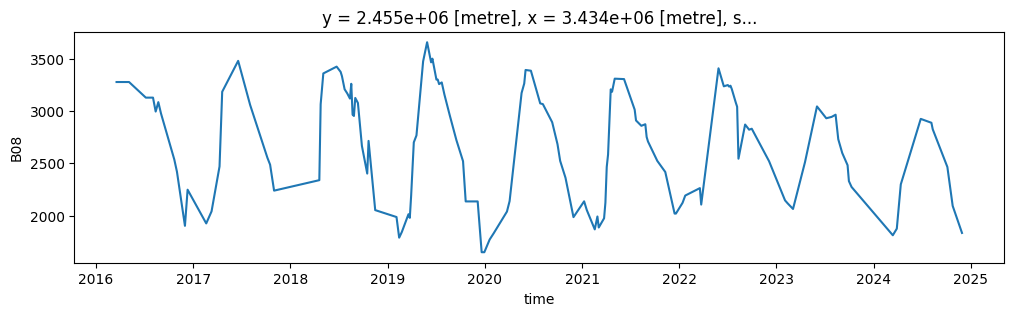

In [19]:
ts_S2.cube.B08.isel(x=200, y=90).plot(figsize=(12, 3))

## 6. Saving the Datacube as a file

### 6.1. Default export

It is possible to export the Datacube in **NetCDF** (Network Common Data Form) or in **CSV** (Comma-Separated Values).


In [20]:
%%time

# export to NETcdf
ts_S2.to_nc(data_dir)

#export to csv
#ts_S2.to_csv(data_dir)

CPU times: user 50.9 s, sys: 12.7 s, total: 1min 3s
Wall time: 19.8 s


The output filename is automaticaly made with the following syntax:
```sh
fid-<gid>_<array type>_<start date>-<end date>.nc
```


In [21]:
%%time

netcdf = [i for i in os.listdir(data_dir) if i.endswith('.nc')]
netcdf

CPU times: user 258 µs, sys: 1.35 ms, total: 1.61 ms
Wall time: 2.9 ms


['fid-None_sat_image_2016-01-01 00:00:00-2025-01-01 00:00:00.nc']